In [1]:
from gerrychain import (GeographicPartition, Graph, MarkovChain,
                        updaters, Election, constraints, accept)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [2]:
from gerrychain.random import random
random.seed(12345678)

In [1]:
# Import data

In [3]:
la_graph = Graph.from_file("./la_election/la_election_shapefile.shp")

In [2]:
# Define elections

In [4]:
elections = [
    Election("SEN20", {"Democratic": "G20USSD", "Republican": "G20USSR"}),
    Election("PRES20", {"Democratic": "G20PRED", "Republican": "G20PRER"})
]

In [5]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [3]:
# Set up random walk

In [6]:
initial_partition = GeographicPartition(graph=la_graph, assignment="CD", updaters=my_updaters)

In [4]:
# Calculate ideal population

In [7]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [8]:
proposal = partial(recom, pop_col="TOTPOP", pop_target=ideal_population, epsilon=0.02, node_repeats=2)

In [9]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [10]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [5]:
# Create the Markov Chain

In [11]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[pop_constraint, compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=5000
)

In [6]:
# Efficiency gap function

In [20]:
def efficiency_gap(partition, election_name):
    wasted_votes_dem = 0
    wasted_votes_rep = 0
    total_votes = 0

    # Accessing vote counts for each party in each district
    dem_votes_by_district = partition[election_name].counts("Democratic")
    rep_votes_by_district = partition[election_name].counts("Republican")

    # Iterate through each district's vote counts
    for dem_votes, rep_votes in zip(dem_votes_by_district, rep_votes_by_district):
        district_total_votes = dem_votes + rep_votes
        total_votes += district_total_votes

        # Calculate wasted votes based on who wins the district
        if dem_votes > rep_votes:
            # Democratic wins
            wasted_votes_dem += dem_votes - (district_total_votes // 2 + 1)
            wasted_votes_rep += rep_votes
        else:
            # Republican wins
            wasted_votes_rep += rep_votes - (district_total_votes // 2 + 1)
            wasted_votes_dem += dem_votes

    # Calculate the efficiency gap, Republican minus Democrat wasted votes normalized by total votes
    efficiency_gap = (wasted_votes_rep - wasted_votes_dem) / total_votes
    return efficiency_gap


In [7]:
# Mean median difference function

In [26]:
def mean_median_difference(part, election_name, party):
    # Extract vote percentages for the specified election and party
    vote_percentages = part[election_name].percents(party)
    
    mean_percentage = np.mean(vote_percentages)
    median_percentage = np.median(vote_percentages)
    
    # Calculate the mean-median difference
    mean_median_diff = mean_percentage - median_percentage
    
    return mean_median_diff


In [8]:
# dem_won_districts to calculate districts won by Democrats

In [27]:
def dem_won_districts(part, election_name):
    won_districts = 0
    vote_percentages = part[election_name].percents("Democratic")
    for percent in vote_percentages:
        if percent > 0.50:  # Checking if the Democratic vote percentage is greater than 50%
            won_districts += 1
    return won_districts


In [9]:
# Calculate the metrics for both elections

In [29]:
efficiency_gaps_sen20 = []
efficiency_gaps_pres20 = []
mean_medians_sen20_dem = []
mean_medians_pres20_dem = []
dem_wins_sen20 = []
dem_wins_pres20 = []

for partition in chain:
    efficiency_gaps_sen20.append(efficiency_gap(partition, "SEN20"))
    efficiency_gaps_pres20.append(efficiency_gap(partition, "PRES20"))
    mean_medians_sen20_dem.append(mean_median_difference(partition, "SEN20", "Democratic"))
    mean_medians_pres20_dem.append(mean_median_difference(partition, "PRES20", "Democratic"))
    dem_wins_sen20.append(dem_won_districts(partition, "SEN20"))
    dem_wins_pres20.append(dem_won_districts(partition, "PRES20"))

In [10]:
# Create box plots for efficiency gap

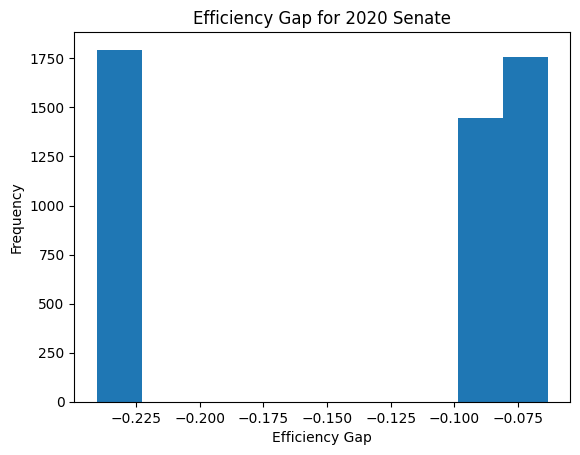

In [35]:
plt.figure()
plt.hist(efficiency_gaps_sen20, align='left')
plt.title('Efficiency Gap for 2020 Senate')
plt.xlabel('Efficiency Gap')
plt.ylabel('Frequency')
plt.savefig('EG_Sen.png', format='png', dpi=300)
plt.show()

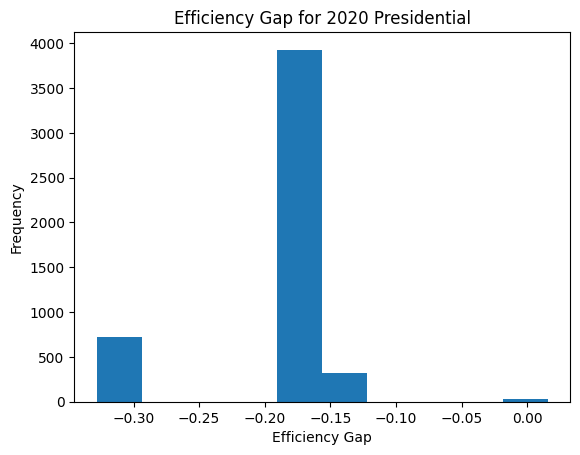

In [36]:
plt.figure()
plt.hist(efficiency_gaps_pres20, align='left')
plt.title('Efficiency Gap for 2020 Presidential')
plt.xlabel('Efficiency Gap')
plt.ylabel('Frequency')
plt.savefig('EG_Pres.png', format='png', dpi=300)
plt.show()

In [11]:
# Create box plots for mean-median difference

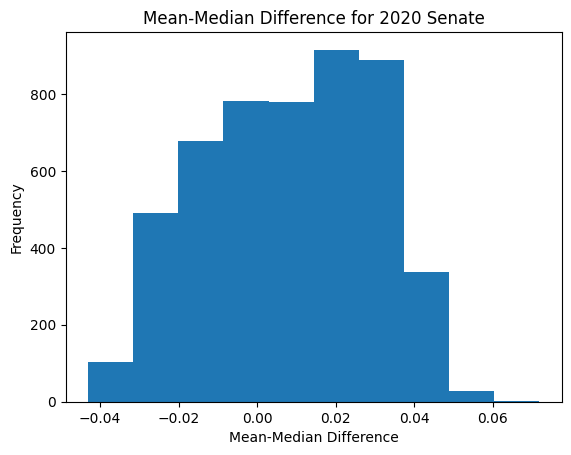

In [37]:
plt.figure()
plt.hist(mean_medians_sen20_dem, align='left')
plt.title('Mean-Median Difference for 2020 Senate')
plt.xlabel('Mean-Median Difference')
plt.ylabel('Frequency')
plt.savefig('MM_Sen.png', format='png', dpi=300)
plt.show()

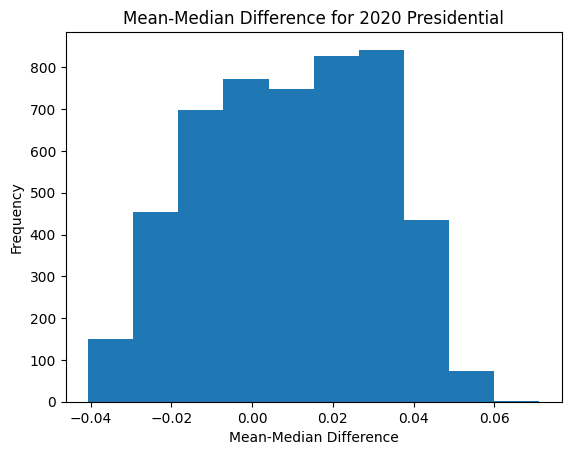

In [38]:
plt.figure()
plt.hist(mean_medians_pres20_dem, align='left')
plt.title('Mean-Median Difference for 2020 Presidential')
plt.xlabel('Mean-Median Difference')
plt.ylabel('Frequency')
plt.savefig('MM_Pres.png', format='png', dpi=300)
plt.show()

In [12]:
# Create box plots for districts won by democrats

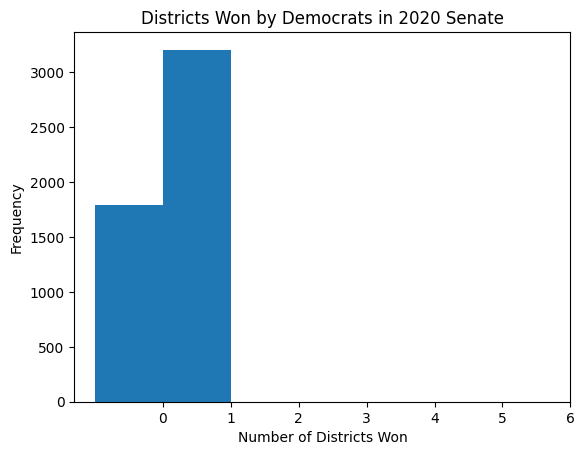

In [49]:
plt.figure()
plt.hist(dem_wins_sen20, bins=np.arange(7) - 0.5, align='left')
plt.title('Districts Won by Democrats in 2020 Senate')
plt.xlabel('Number of Districts Won')
plt.ylabel('Frequency')
plt.xticks(np.arange(7))
plt.savefig('Dem_Won_Sen.png', format='png', dpi=300)
plt.show()

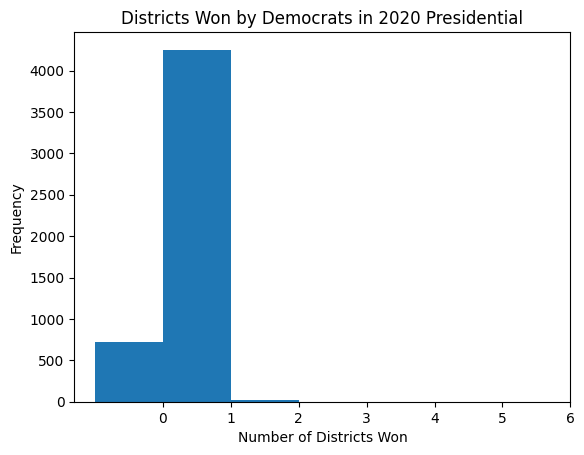

In [50]:
plt.figure()
plt.hist(dem_wins_pres20, bins=np.arange(7) - 0.5, align='left')
plt.title('Districts Won by Democrats in 2020 Presidential')
plt.xlabel('Number of Districts Won')
plt.ylabel('Frequency')
plt.xticks(np.arange(7))
plt.savefig('Dem_Won_Pres.png', format='png', dpi=300)
plt.show()